In [1]:
from physDBD import ImportHelper, DataDesc, ParamsTraj, RxnInputsLayer, ParamsTETraj, RxnModel, ConvertParams0ToNMomentsLayer, ComparisonModel, ComparisonInputsLayer
import numpy as np
import tensorflow as tf
import sys
import os
import datetime
import pickle

In [2]:
import matplotlib.pyplot as plt

In [3]:
def get_data_dir():
    data_dir = "/Users/oernst/Documents/papers/2021_03_draft/stochastic_simulations/ml_training_data/data_gillespie/"
    vol_exp = 14
    no_ip3r = 100
    vol_dir = "vol_exp_%02d" % vol_exp
    no_ip3r_dir = "ip3r_%05d" % no_ip3r
    data_dir = os.path.join(data_dir, vol_dir, no_ip3r_dir)
    return data_dir

# Transformation

## Calculate

In [5]:
data_desc = DataDesc(
    no_seeds=100,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [6]:
data = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    data[ip3] = ImportHelper.import_gillespie_ssa_from_data_desc(
        data_desc=data_desc,
        data_dir=os.path.join(get_data_dir(),ip3)
        )

In [7]:
data["ip3_0p100"].shape

(400, 100, 2)

In [8]:
trans_means = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    trans_means[ip3] = np.mean(data[ip3],axis=(0,1))

print("Means: ", trans_means)    

trans_mean = np.mean(np.array(list(trans_means.values())),axis=0)
print("Means: ", trans_mean)

Means:  {'ip3_0p100': array([371.56195, 601.2577 ]), 'ip3_2p000': array([ 3451.841975, 12051.191425])}
Means:  [1911.7019625 6326.2245625]


In [9]:
sums = {}
lengths = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    ds = data[ip3].shape
    arr = np.reshape(pow(data[ip3] - trans_mean,2),(ds[0]*ds[1],ds[2]))
    rs = arr.shape
    sums[ip3] = np.sum(arr,axis=0)
    lengths[ip3] = rs[0]

length = np.sum(list(lengths.values()))
trans_std = np.sum(list(sums.values()), axis=0) / length
trans_std = np.sqrt(trans_std)

print("Std. devs: ", trans_std)

Std. devs:  [1729.21588444 5724.97054985]


## Export

In [10]:
np.savetxt("cache/trans_mean.txt",trans_mean)
np.savetxt("cache/trans_std.txt",trans_std)

## Import

In [11]:
trans_mean = np.loadtxt("cache/trans_mean.txt")
trans_std = np.loadtxt("cache/trans_std.txt")

## Plot

In [12]:
data_desc = DataDesc(
    no_seeds=1,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [13]:
data = {}
for ip3 in ["ip3_0p100","ip3_2p000"]:
    data[ip3] = ImportHelper.import_gillespie_ssa_from_data_desc(
        data_desc=data_desc,
        data_dir=os.path.join(get_data_dir(),ip3)
        )

Text(0.5, 0, 'Timepoint (x 0.1s)')

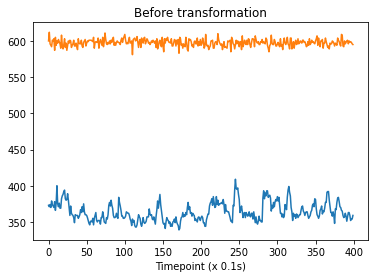

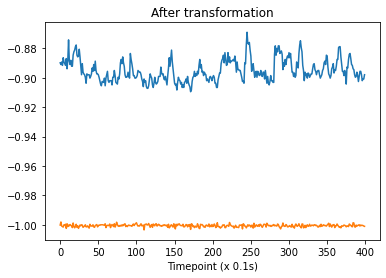

In [14]:
ex_traj = data["ip3_0p100"][:,0]

plt.figure()
plt.plot(ex_traj)
plt.title("Before transformation")
plt.xlabel("Timepoint (x 0.1s)")

plt.figure()
plt.plot((ex_traj - trans_mean)/trans_std)
plt.title("After transformation")
plt.xlabel("Timepoint (x 0.1s)")

# PCA params

## Import transformation

In [15]:
trans_mean = np.loadtxt("cache/trans_mean.txt")
trans_std = np.loadtxt("cache/trans_std.txt")

## Import, calculate PCA

In [16]:
data_desc = DataDesc(
    no_seeds=1200,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [17]:
if not os.path.isdir("cache/cache_params"):
    os.mkdir("cache/cache_params")

In [18]:
for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    print("IP3: ", ip3)
    data = ImportHelper.import_gillespie_ssa_from_data_desc(
        data_desc=data_desc,
        data_dir=os.path.join(get_data_dir(), ip3)
        )
    
    data = (data - trans_mean) / trans_std
    
    # Create params traj and export
    muh = np.zeros(1)
    varh_diag = np.ones(1)
    params_traj = ParamsTraj.fromPCA(data, data_desc.times, muh, varh_diag)

    # Export
    params_traj.export("cache/cache_params/%s.txt" % ip3)

IP3:  ip3_0p100
IP3:  ip3_0p200
IP3:  ip3_0p300
IP3:  ip3_0p400
IP3:  ip3_0p500
IP3:  ip3_0p600
IP3:  ip3_0p700
IP3:  ip3_0p800
IP3:  ip3_0p900
IP3:  ip3_1p000
IP3:  ip3_1p100
IP3:  ip3_1p200
IP3:  ip3_1p300
IP3:  ip3_1p400
IP3:  ip3_1p500
IP3:  ip3_1p600
IP3:  ip3_1p700
IP3:  ip3_1p800
IP3:  ip3_1p900
IP3:  ip3_2p000


## Plot

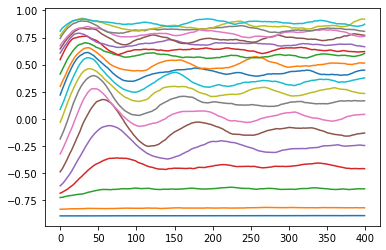

In [19]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)

    b0 = [x.b[0] for x in params_traj.params_traj]

    plt.plot(b0)

# Derivatives

In [20]:
if not os.path.isdir("cache/cache_derivs"):
    os.mkdir("cache/cache_derivs")

In [21]:
alphas = {
    "wt00": 100.0,
    "wt01": 5000.0,
    "b0": 100.0,
    "b1": 100.0,
    "sig2": 5000.0
}
non_zero_vals = list(alphas.keys())

In [22]:
for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    print("IP3: ", ip3)
    
    # Import params traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    
    # Differentiate
    paramsTE_traj = params_traj.differentiate_with_TVR(
        alphas=alphas, 
        no_opt_steps=10, 
        non_zero_vals=non_zero_vals
        )
    
    # Export
    paramsTE_traj.export("cache/cache_derivs/%s.txt" % ip3)

IP3:  ip3_0p100
IP3:  ip3_0p200
IP3:  ip3_0p300
IP3:  ip3_0p400
IP3:  ip3_0p500
IP3:  ip3_0p600
IP3:  ip3_0p700
IP3:  ip3_0p800
IP3:  ip3_0p900
IP3:  ip3_1p000
IP3:  ip3_1p100
IP3:  ip3_1p200
IP3:  ip3_1p300
IP3:  ip3_1p400
IP3:  ip3_1p500
IP3:  ip3_1p600
IP3:  ip3_1p700
IP3:  ip3_1p800
IP3:  ip3_1p900
IP3:  ip3_2p000


## Plot

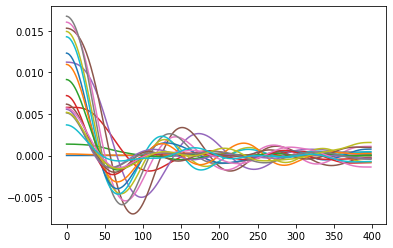

In [23]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    # Import params TE traj
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    b0 = [x.b_TE[0] for x in paramsTE_traj.paramsTE_traj]

    # Plot
    plt.plot(b0)

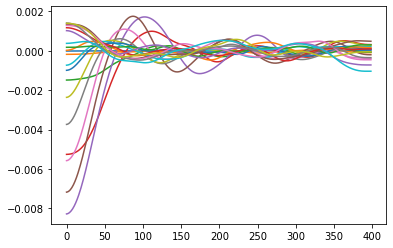

In [24]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    # Import params TE traj
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    wt00 = [x.wt_TE[0,0] for x in paramsTE_traj.paramsTE_traj]

    # Plot
    plt.plot(wt00)

## Re-integrate

In [4]:
if not os.path.isdir("cache/cache_filtered"):
    os.mkdir("cache/cache_filtered")

In [5]:
for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params and TE traj
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    
    b1 = np.array([p.b[1] for p in params_traj.params_traj])
    b1_mean = np.mean(b1)

    # Integrate
    no_steps = len(params_traj.params_traj) - 1
    params_traj_filtered = ParamsTraj.fromIntegrating(
        paramsTE_traj=paramsTE_traj,
        params_init=params_traj.params_traj[0],
        tpt_start=0,
        no_steps=no_steps,
        constant_vals_lf={
            "sig2": 1.5 * 1e-6,
            "b1": b1_mean,
            "wt01": 0.00005
        }
        )
    
    # Export
    params_traj_filtered.export("cache/cache_filtered/%s.txt" % ip3)

## Plot

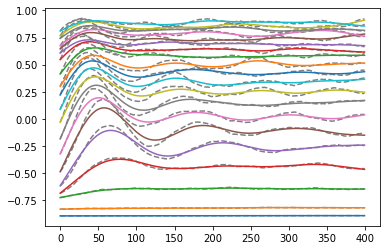

In [6]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params traj
    params_traj_filtered = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    
    b0_filtered = [x.b[0] for x in params_traj_filtered.params_traj]
    b0 = [x.b[0] for x in params_traj.params_traj]

    plt.plot(b0,color="gray",linestyle="dashed")
    plt.plot(b0_filtered)

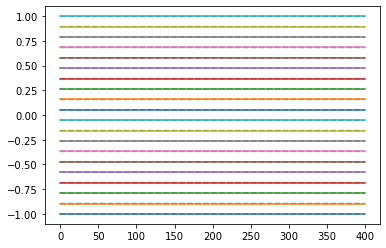

In [7]:
plt.figure()

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_0p400","ip3_0p500",
           "ip3_0p600","ip3_0p700","ip3_0p800","ip3_0p900","ip3_1p000",
           "ip3_1p100","ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
           "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    
    # Import params traj
    params_traj_filtered = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % ip3, nv=2, nh=1)
    
    b1_filtered = [x.b[1] for x in params_traj_filtered.params_traj]
    b1 = [x.b[1] for x in params_traj.params_traj]

    plt.plot(b1,color="gray",linestyle="dashed")
    plt.plot(b1_filtered)

# Network

In [4]:
data_desc = DataDesc(
    no_seeds=1200,
    time_start=10,
    time_end=50,
    time_interval=0.1,
    species=["ca2i","ip3"]
)

In [5]:
# Freqs, coffs for fourier
freqs = np.array([1.,2.,3.,4.,5.,6.])
freqs = 2.0 * np.pi * freqs / data_desc.no_times

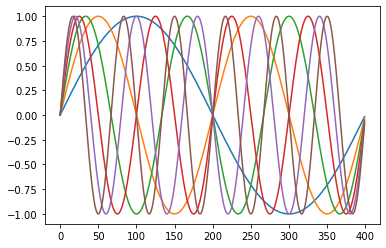

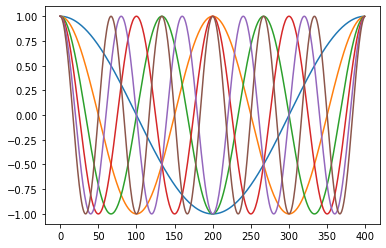

In [6]:
no_tpts = np.arange(0,data_desc.no_times)

plt.figure()
for freq in freqs:
    plt.plot(np.sin(freq * no_tpts))

plt.figure()
for freq in freqs:
    plt.plot(np.cos(freq * no_tpts))

## Reactions

In [31]:
# Rxns
rxn_specs = [
    ("EAT",0,1),
    ("EAT",1,0),
    ("EAT",2,0),
    ("EAT",0,2),
    ("EAT",1,2),
    ("EAT",2,1),
    ("BIRTH",0),
    ("BIRTH",1),
    ("BIRTH",2),
    ("DEATH",0),
    ("DEATH",1),
    ("DEATH",2)
    ]

In [32]:
muh_sin_coeffs_init = np.full(len(freqs),0.0)
muh_cos_coeffs_init = np.full(len(freqs),0.0)
varh_sin_coeffs_init = np.full(len(freqs),0.0)
varh_cos_coeffs_init = np.full(len(freqs),0.0)

In [33]:
# Reaction input layer
rxn_lyr = RxnInputsLayer.construct(
    nv=2,
    nh=1,
    freqs=freqs,
    muh_sin_coeffs_init=muh_sin_coeffs_init,
    muh_cos_coeffs_init=muh_cos_coeffs_init,
    varh_sin_coeffs_init=varh_sin_coeffs_init,
    varh_cos_coeffs_init=varh_cos_coeffs_init,
    rxn_specs=rxn_specs
    )

## Subnet

In [7]:
# Shallow
'''
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu', kernel_constraint=tf.keras.constraints.max_norm(1.)),
    tf.keras.layers.Dropout(0.5)
])
'''

# Deep
subnet = tf.keras.Sequential([
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(500, kernel_constraint=tf.keras.constraints.max_norm(5.)), tf.keras.layers.PReLU(), tf.keras.layers.Dropout(0.3)
])

## Model

In [35]:
model = RxnModel.construct(
    nv=2,
    nh=1,
    rxn_lyr=rxn_lyr,
    subnet=subnet,
    non_zero_outputs=["wt00_TE","b0_TE"]
    )

## Normalizations

In [8]:
def join_dicts(existing_dict, new_dict):
    for key, val in new_dict.items():
        if not key in existing_dict:
            existing_dict[key] = val
        else:
            existing_dict[key] = np.concatenate((existing_dict[key],val))
    return existing_dict

In [9]:
train_inputs = {}
train_outputs = {}

for ip3 in ["ip3_0p400","ip3_0p500","ip3_0p600","ip3_0p700",
            "ip3_0p800","ip3_0p900","ip3_1p000"]:
    print("IP3: ", ip3)
    
    # Import
    params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    
    # Training data
    train_inputs0 = params_traj.get_tf_inputs_assuming_params0()
    train_outputs0 = paramsTE_traj.get_tf_outputs_assuming_params0(non_zero_outputs=["wt00_TE","b0_TE"])
    
    train_inputs = join_dicts(train_inputs, train_inputs0)
    train_outputs = join_dicts(train_outputs, train_outputs0)

IP3:  ip3_0p400
IP3:  ip3_0p500
IP3:  ip3_0p600
IP3:  ip3_0p700
IP3:  ip3_0p800
IP3:  ip3_0p900
IP3:  ip3_1p000


In [10]:
valid_inputs = {}
valid_outputs = {}

for ip3 in ["ip3_0p100","ip3_0p200","ip3_0p300","ip3_1p100",
            "ip3_1p200","ip3_1p300","ip3_1p400","ip3_1p500",
            "ip3_1p600","ip3_1p700","ip3_1p800","ip3_1p900","ip3_2p000"]:
    print("IP3: ", ip3)
    
    # Import
    params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % ip3, nv=2, nh=1)
    paramsTE_traj = ParamsTETraj.fromFile("cache/cache_derivs/%s.txt" % ip3, nv=2, nh=1)
    
    # Training data
    valid_inputs0 = params_traj.get_tf_inputs_assuming_params0()
    valid_outputs0 = paramsTE_traj.get_tf_outputs_assuming_params0(non_zero_outputs=["wt00_TE","b0_TE"])
    
    valid_inputs = join_dicts(valid_inputs, valid_inputs0)
    valid_outputs = join_dicts(valid_outputs, valid_outputs0)

IP3:  ip3_0p100
IP3:  ip3_0p200
IP3:  ip3_0p300
IP3:  ip3_1p100
IP3:  ip3_1p200
IP3:  ip3_1p300
IP3:  ip3_1p400
IP3:  ip3_1p500
IP3:  ip3_1p600
IP3:  ip3_1p700
IP3:  ip3_1p800
IP3:  ip3_1p900
IP3:  ip3_2p000


In [11]:
# Normalize outputs

# Normalization size
percent = 1.0
norm_size = int(percent * len(train_outputs["wt00_TE"]))
print("Calculating output normalization from: %d samples" % norm_size)

# Normalize training
train_outputs_mean = {}
train_outputs_std_dev = {}
train_outputs_norm = {}
for key, val in train_outputs.items():
    idxs = np.arange(0,len(val))
    idxs_subset = np.random.choice(idxs,size=norm_size,replace=False)
    val_subset = val[idxs_subset]

    # Mean, std
    train_outputs_mean[key] = np.mean(val_subset,axis=0)
    train_outputs_std_dev[key] = np.std(val_subset,axis=0)

    if abs(train_outputs_mean[key]) < 1e-6:
        train_outputs_mean[key] = 0.0
    if abs(train_outputs_std_dev[key]) < 1e-6:
        train_outputs_std_dev[key] = 1.0

    train_outputs_norm[key] = (val - train_outputs_mean[key]) / train_outputs_std_dev[key]

# Normalize validation
valid_outputs_norm = {}
for key, val in valid_outputs.items():
    valid_outputs_norm[key] = (val - train_outputs_mean[key]) / train_outputs_std_dev[key]

Calculating output normalization from: 2793 samples


In [12]:
# Save the output mean/std dev
with open("cache/cache_outputs_mean.txt",'wb') as f:
    pickle.dump(train_outputs_mean, f)
with open("cache/cache_outputs_std_dev.txt",'wb') as f:
    pickle.dump(train_outputs_std_dev, f)

# Try to load
with open("cache/cache_outputs_mean.txt",'rb') as f:
    train_outputs_mean_check = pickle.load(f)
with open("cache/cache_outputs_std_dev.txt",'rb') as f:
    train_outputs_std_dev_check = pickle.load(f)

print(train_outputs_mean, " ; ", train_outputs_mean_check)
print(train_outputs_std_dev, " ; ", train_outputs_std_dev_check)

{'wt00_TE': -0.0003327316447257071, 'b0_TE': 0.0007871616510790033}  ;  {'wt00_TE': -0.0003327316447257071, 'b0_TE': 0.0007871616510790033}
{'wt00_TE': 0.0014066331994188395, 'b0_TE': 0.003877785990272666}  ;  {'wt00_TE': 0.0014066331994188395, 'b0_TE': 0.003877785990272666}


In [15]:
# Reaction layer to use for the normalization
rxn_lyr_norm = RxnInputsLayer.construct(
    nv=2,
    nh=1,
    freqs=np.array([freqs[-1]]),
    muh_sin_coeffs_init=np.array([1.0]),
    muh_cos_coeffs_init=np.array([1.0]),
    varh_sin_coeffs_init=np.array([1.0]),
    varh_cos_coeffs_init=np.array([1.0]),
    rxn_specs=rxn_specs
    )

# Normalize inputs
model.calculate_rxn_normalization(
    rxn_lyr=rxn_lyr_norm, 
    inputs=train_inputs, 
    percent=0.2
    )

NameError: name 'rxn_specs' is not defined

In [46]:
print("Reaction normalization: Mean: ", model.rxn_mean)
print("Reaction normalization: Std dev: ", model.rxn_std_dev)

Reaction normalization: Mean:  [ 2.16811106e-01 -2.16811106e-01  6.67434558e-02 -6.67434558e-02
  6.67429268e-02 -2.16811106e-01  2.16811106e-01 -6.67434558e-02
  6.67434558e-02  6.67440370e-02  4.09962207e-01  5.92588458e-06
  6.06917083e-01  2.32255469e-14 -5.23281395e-02  3.84847313e-01
  5.92631159e-06 -6.06917083e-01  9.39439702e-14 -5.23278527e-02
  4.66896147e-02 -4.31933582e-01 -9.82853687e-10  4.16114461e-03
  2.99854241e-02  4.66896072e-02  2.95183748e-01 -1.05775874e-10
 -4.16114973e-03  2.99854726e-02 -6.22592747e-01  0.00000000e+00
 -2.02503372e-02  0.00000000e+00 -1.01236934e-02  0.00000000e+00
  1.60526579e-05  0.00000000e+00 -3.77367049e-01 -1.88682079e-01
 -1.32073924e-01  3.40409565e-06 -3.20955795e-09 -1.26796224e-14
 -8.47995952e-02  6.22592747e-01  0.00000000e+00  2.02503372e-02
  0.00000000e+00 -1.01266429e-02  0.00000000e+00 -1.60526579e-05
  0.00000000e+00  3.77367049e-01 -1.88685164e-01 -1.32073954e-01
  3.40447377e-06 -6.06027273e-09  1.13645455e-13 -8.4799610

# Train

In [13]:
# Test input to the model
input_build = params_traj.params_traj[0].get_tf_input_assuming_params0(tpt=1)
input_build = join_dicts(input_build, params_traj.params_traj[0].get_tf_input_assuming_params0(tpt=1))

print("Test input: ", input_build)
print("Test output: ", model(input_build))

Test input:  {'tpt': array([1., 1.]), 'wt': array([[[-6.37040514e-01,  5.00000000e-05]],

       [[-6.37040514e-01,  5.00000000e-05]]]), 'b': array([[0.80914162, 0.99994401],
       [0.80914162, 0.99994401]]), 'sig2': array([1.5e-06, 1.5e-06])}


NameError: name 'model' is not defined

In [48]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [66]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=loss_fn,
              run_eagerly=False)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
    histogram_freq=1,
    write_graph=False
    )

val_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'trained/weights_lowest_val', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='auto', 
    save_frequency=1
    )

model.fit(
    train_inputs, 
    train_outputs_norm, 
    epochs=25, 
    validation_data=(valid_inputs,valid_outputs_norm),
    callbacks=[tensorboard_callback,val_checkpoint],
    batch_size=64
)

Epoch 1/25
44/44 [==============================] - 91s 807ms/step - loss: 1.5515 - b0_TE_loss: 0.9427 - wt00_TE_loss: 0.6088 - val_loss: 4.4823 - val_b0_TE_loss: 3.2573 - val_wt00_TE_loss: 1.2251

Epoch 00001: val_loss improved from inf to 4.48233, saving model to trained_lowest_val
INFO:tensorflow:Assets written to: trained_lowest_val/assets
INFO:tensorflow:Assets written to: trained_lowest_val/assets
Epoch 2/25
44/44 [==============================] - 13s 291ms/step - loss: 0.7824 - b0_TE_loss: 0.4892 - wt00_TE_loss: 0.2932 - val_loss: 0.2971 - val_b0_TE_loss: 0.1838 - val_wt00_TE_loss: 0.1132

Epoch 00002: val_loss improved from 4.48233 to 0.29707, saving model to trained_lowest_val
INFO:tensorflow:Assets written to: trained_lowest_val/assets
INFO:tensorflow:Assets written to: trained_lowest_val/assets
Epoch 3/25
44/44 [==============================] - 12s 283ms/step - loss: 0.5977 - b0_TE_loss: 0.3610 - wt00_TE_loss: 0.2367 - val_loss: 1.9990 - val_b0_TE_loss: 1.4592 - val_wt00_T

In [22]:
%tensorboard --logdir logs

## Save model

In [21]:
# Save
model.save("trained/trained", save_traces=False)

INFO:tensorflow:Assets written to: trained/trained/assets


## Import trained model

In [67]:
model_trained = tf.keras.models.load_model("trained/trained_lowest_val")

In [42]:
params_traj = ParamsTraj.fromFile("cache/cache_params/%s.txt" % "ip3_0p400", nv=2, nh=1)
int_input = params_traj.params_traj[0].get_tf_input_assuming_params0(tpt=0)
print(int_input)
int_output = model_trained(int_input)
print(int_output)

{'tpt': array([0.]), 'wt': array([[[-2.46492819e-01,  8.98171166e-05]]]), 'b': array([[-0.68373541, -0.6834573 ]]), 'sig2': array([1.49628027e-06])}
{'wt00_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-2.8467426]], dtype=float32)>, 'b0_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.91050607]], dtype=float32)>}


## Integrate

In [43]:
# Load mean / std. dev. output normalization
with open("cache/cache_outputs_mean.txt",'rb') as f:
    train_outputs_mean = pickle.load(f)
with open("cache/cache_outputs_std_dev.txt",'rb') as f:
    train_outputs_std_dev = pickle.load(f)

train_outputs_mean

{'wt00_TE': -0.00031232439026682136, 'b0_TE': 0.0006091167043483266}

In [46]:
params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % "ip3_0p400", nv=2, nh=1)
params_start = params_traj.params_traj[0]

params_traj_int = model_trained.integrate(
    params_start=params_start,
    tpt_start=0,
    no_steps=120,
    time_interval=0.1,
    output_mean=train_outputs_mean,
    output_std_dev=train_outputs_std_dev
)

(1, 1), dtype=float32, numpy=array([[0.49765998]], dtype=float32)>}
After re-norm:  {'wt00_TE': -0.002695117362870041, 'b0_TE': 0.002458719013591484}
Before re-norm:  {'wt00_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.6752613]], dtype=float32)>, 'b0_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.47843054]], dtype=float32)>}
After re-norm:  {'wt00_TE': -0.0026827233415791327, 'b0_TE': 0.0023872508999217903}
Before re-norm:  {'wt00_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.6736778]], dtype=float32)>, 'b0_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.46905047]], dtype=float32)>}
After re-norm:  {'wt00_TE': -0.00268048284041816, 'b0_TE': 0.002352388937652749}
Before re-norm:  {'wt00_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.6514827]], dtype=float32)>, 'b0_TE': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.44794768]], dtype=float32)>}
After re-norm:  {'wt00_TE': -0.0026490780411140176, 'b0

In [20]:
wt00 = [x.wt[0,0] for x in params_traj_int.params_traj]
b0 = [x.b[0] for x in params_traj_int.params_traj]

wt00_true = [x.wt[0,0] for x in params_traj.params_traj]
b0_true = [x.b[0] for x in params_traj.params_traj]

plt.figure()
plt.plot(wt00)
plt.plot(wt00_true)

plt.figure()
plt.plot(b0)
plt.plot(b0_true)

NameError: name 'params_traj_int' is not defined

In [31]:
wt00

[-0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607,
 -0.05707206577062607]

# Train comparison model

In [13]:
muh_sin_coeffs_init = np.full(len(freqs),0.0)
muh_cos_coeffs_init = np.full(len(freqs),0.0)
varh_sin_coeffs_init = np.full(len(freqs),0.0)
varh_cos_coeffs_init = np.full(len(freqs),0.0)

compare_lyr = ComparisonInputsLayer.construct(
    nv=2,
    nh=1,
    freqs=freqs,
    muh_sin_coeffs_init=muh_sin_coeffs_init,
    muh_cos_coeffs_init=muh_cos_coeffs_init,
    varh_sin_coeffs_init=varh_sin_coeffs_init,
    varh_cos_coeffs_init=varh_cos_coeffs_init
    )

In [14]:
model = ComparisonModel.construct(
    nv=2,
    nh=1,
    compare_lyr=compare_lyr,
    subnet=subnet,
    non_zero_outputs=["wt00_TE","b0_TE"]
    )

In [15]:
# Reaction layer to use for the normalization
compare_lyr_norm = ComparisonInputsLayer.construct(
    nv=2,
    nh=1,
    freqs=np.array([freqs[-1]]),
    muh_sin_coeffs_init=np.array([1.0]),
    muh_cos_coeffs_init=np.array([1.0]),
    varh_sin_coeffs_init=np.array([1.0]),
    varh_cos_coeffs_init=np.array([1.0])
    )

# Normalize inputs
model.calculate_param_normalization(
    compare_lyr=compare_lyr_norm,
    inputs=train_inputs, 
    percent=1.0
    )

Calculating input normalization from: 2793 samples


In [16]:
print("Param normalization: Mean: ", model.param_mean)
print("Param normalization: Std dev: ", model.param_std_dev)

Param normalization: Mean:  [-7.1040970e-01  5.6259112e-05 -1.1349836e-01 -3.6753947e-01
  0.0000000e+00 -1.1296308e-03  1.0088723e+00]
Param normalization: Std dev:  [2.4808222e-01 1.7488783e-05 4.6088919e-01 2.1056812e-01 1.0000000e+00
 5.0011683e-01 5.0011641e-01]


In [17]:
input0 = {
    "tpt": np.reshape(np.arange(0,399).astype('float32'),(399,1))
}

muh_layer = compare_lyr_norm.params0toParams.layer_muh["0"]
muh_output0 = muh_layer(input0).numpy()

varh_diag_layer = compare_lyr_norm.params0toParams.layer_varh_diag["0"]
varh_diag_output0 = varh_diag_layer(input0).numpy()

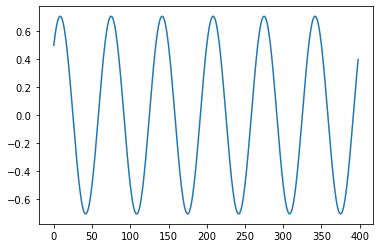

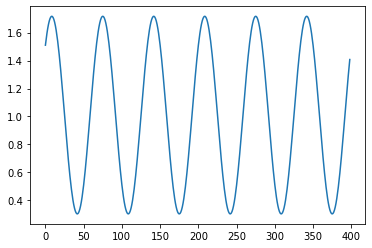

In [18]:
plt.figure()
plt.plot(muh_output0)

plt.figure()
plt.plot(varh_diag_output0)

## Train

In [19]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=loss_fn,
              run_eagerly=False)

logdir = os.path.join("logs_compare", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
    histogram_freq=1,
    write_graph=False
    )

val_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'trained_compare/weights_lowest_val', 
    monitor='val_loss', 
    verbose=1,
    save_best_only=True, 
    save_weights_only=True,
    mode='auto', 
    save_frequency=1
    )

model.fit(
    train_inputs, 
    train_outputs_norm, 
    epochs=25, 
    validation_data=(valid_inputs,valid_outputs_norm),
    callbacks=[tensorboard_callback,val_checkpoint],
    batch_size=64
)

model.save_weights("trained_compare/weights_final")

Epoch 1/25
44/44 [==============================] - 6s 61ms/step - loss: 1.8299 - b0_TE_loss: 0.9445 - wt00_TE_loss: 0.8854 - val_loss: 8.0232 - val_b0_TE_loss: 2.9472 - val_wt00_TE_loss: 5.0760

Epoch 00001: val_loss improved from inf to 8.02317, saving model to trained_compare/weights_lowest_val
Epoch 2/25
44/44 [==============================] - 2s 37ms/step - loss: 0.5789 - b0_TE_loss: 0.3098 - wt00_TE_loss: 0.2692 - val_loss: 0.4229 - val_b0_TE_loss: 0.1929 - val_wt00_TE_loss: 0.2299

Epoch 00002: val_loss improved from 8.02317 to 0.42285, saving model to trained_compare/weights_lowest_val
Epoch 3/25
44/44 [==============================] - 2s 36ms/step - loss: 0.4800 - b0_TE_loss: 0.2398 - wt00_TE_loss: 0.2402 - val_loss: 0.4965 - val_b0_TE_loss: 0.1834 - val_wt00_TE_loss: 0.3130

Epoch 00003: val_loss did not improve from 0.42285
Epoch 4/25
44/44 [==============================] - 2s 37ms/step - loss: 0.3827 - b0_TE_loss: 0.1975 - wt00_TE_loss: 0.1852 - val_loss: 1.1727 - val_b0

In [34]:
# model.load_weights("trained_compare/weights_lowest_val")
model.load_weights("trained_compare/weights_final")

In [20]:
def make_input_single(idx, train_inputs):
    in0 = {}
    for key,val in train_inputs.items():
        in0[key] = np.array([val[idx]])
    return in0

def make_output_single(idx, train_outputs_norm):
    out0_norm_true = {}
    for key,val in train_outputs_norm.items():
        out0_norm_true[key] = np.array([val[idx]])
    return out0_norm_true

def make_input_multiple(idxs, train_inputs):
    in0 = {}
    for key,val in train_inputs.items():
        in0[key] = np.array(val[idxs])
    return in0

def make_output_multiple(idxs, train_outputs_norm):
    out0_norm_true = {}
    for key,val in train_outputs_norm.items():
        out0_norm_true[key] = np.array(val[idxs])
    return out0_norm_true

def test_output_np(in0):
    out0_norm = model(in0)
    for key,val in out0_norm.items():
        out0_norm[key] = val.numpy()
    return out0_norm

In [21]:
idx = 15
in0 = make_input_single(idx, train_inputs)
out0_norm_true = make_output_single(idx, train_outputs_norm)

print("Input:",in0)
print("Output normalized true:",out0_norm_true)
out0_norm = test_output_np(in0)
print("Output true:", out0_norm)

Input: {'tpt': array([15.]), 'wt': array([[[-3.24692148e-01,  5.00000000e-05]]]), 'b': array([[-0.59687188, -0.68348013]]), 'sig2': array([1.5e-06])}
Output normalized true: {'wt00_TE': array([-3.37807944]), 'b0_TE': array([1.28487952])}
Output true: {'wt00_TE': array([[-3.3489437]], dtype=float32), 'b0_TE': array([[1.4640167]], dtype=float32)}


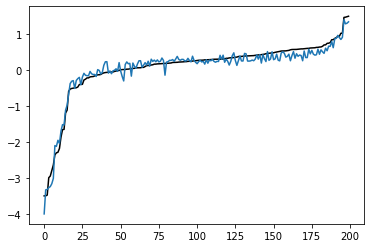

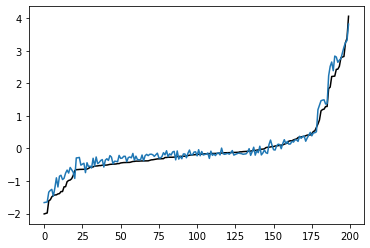

In [22]:
no_inputs = len(train_inputs["wt"])
idxs = np.arange(0,no_inputs)
np.random.shuffle(idxs)
idxs = idxs[:200]

in0 = make_input_multiple(idxs, train_inputs)
out0_norm_true = make_output_multiple(idxs, train_outputs_norm)
out0_norm = test_output_np(in0)

idxs_sort = out0_norm_true["wt00_TE"].argsort()
x_true = out0_norm_true["wt00_TE"][idxs_sort]
x = out0_norm["wt00_TE"][idxs_sort]

plt.figure()
plt.plot(x_true,c="k")
plt.plot(x)

idxs_sort = out0_norm_true["b0_TE"].argsort()
x_true = out0_norm_true["b0_TE"][idxs_sort]
x = out0_norm["b0_TE"][idxs_sort]

plt.figure()
plt.plot(x_true,c="k")
plt.plot(x)

## Integrate

In [23]:
# Load mean / std. dev. output normalization
with open("cache/cache_outputs_mean.txt",'rb') as f:
    train_outputs_mean = pickle.load(f)
with open("cache/cache_outputs_std_dev.txt",'rb') as f:
    train_outputs_std_dev = pickle.load(f)

print(train_outputs_mean)
print(train_outputs_std_dev)

{'wt00_TE': -0.0003327316447257071, 'b0_TE': 0.0007871616510790033}
{'wt00_TE': 0.0014066331994188395, 'b0_TE': 0.003877785990272666}


In [28]:
params_traj = ParamsTraj.fromFile("cache/cache_filtered/%s.txt" % "ip3_0p600", nv=2, nh=1)

tpt_start = 0
params_start = params_traj.params_traj[tpt_start]

params_traj_int = model.integrate(
    params_start=params_start,
    tpt_start=tpt_start,
    no_steps=400,
    time_interval=0.1,
    output_mean=train_outputs_mean,
    output_std_dev=train_outputs_std_dev
)

280009]]), 'sig2': array([1.5e-06])}
Input: 273 : {'tpt': array([273.]), 'wt': array([[[-5.85645142e-01,  5.00000000e-05]]]), 'b': array([[-0.11519379, -0.47280009]]), 'sig2': array([1.5e-06])}
Input: 274 : {'tpt': array([274.]), 'wt': array([[[-5.85981028e-01,  5.00000000e-05]]]), 'b': array([[-0.11410573, -0.47280009]]), 'sig2': array([1.5e-06])}
Input: 275 : {'tpt': array([275.]), 'wt': array([[[-5.86325862e-01,  5.00000000e-05]]]), 'b': array([[-0.11298657, -0.47280009]]), 'sig2': array([1.5e-06])}
Input: 276 : {'tpt': array([276.]), 'wt': array([[[-5.86678638e-01,  5.00000000e-05]]]), 'b': array([[-0.11183877, -0.47280009]]), 'sig2': array([1.5e-06])}
Input: 277 : {'tpt': array([277.]), 'wt': array([[[-5.87037752e-01,  5.00000000e-05]]]), 'b': array([[-0.11066651, -0.47280009]]), 'sig2': array([1.5e-06])}
Input: 278 : {'tpt': array([278.]), 'wt': array([[[-5.87401391e-01,  5.00000000e-05]]]), 'b': array([[-0.10947583, -0.47280009]]), 'sig2': array([1.5e-06])}
Input: 279 : {'tpt': 

Text(0.5, 1.0, 'sig2')

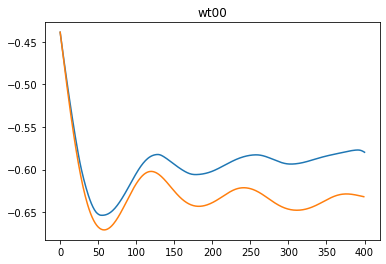

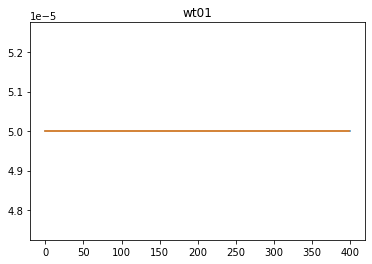

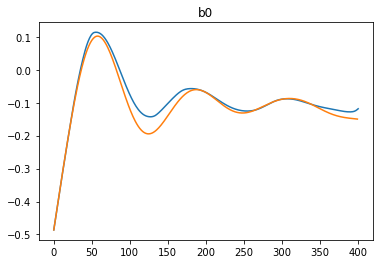

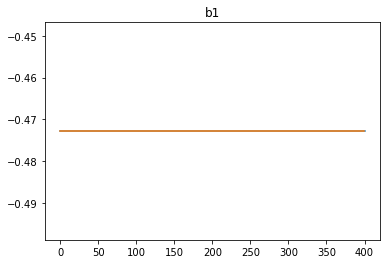

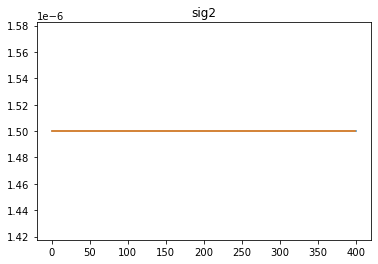

In [29]:
wt00 = [x.wt[0,0] for x in params_traj_int.params_traj]
wt01 = [x.wt[0,1] for x in params_traj_int.params_traj]
b0 = [x.b[0] for x in params_traj_int.params_traj]
b1 = [x.b[1] for x in params_traj_int.params_traj]
sig2 = [x.sig2 for x in params_traj_int.params_traj]

wt00_true = [x.wt[0,0] for x in params_traj.params_traj]
wt01_true = [x.wt[0,1] for x in params_traj.params_traj]
b0_true = [x.b[0] for x in params_traj.params_traj]
b1_true = [x.b[1] for x in params_traj.params_traj]
sig2_true = [x.sig2 for x in params_traj.params_traj]

plt.figure()
plt.plot(wt00)
plt.plot(wt00_true)
plt.title("wt00")

plt.figure()
plt.plot(wt01)
plt.plot(wt01_true)
plt.title("wt01")

plt.figure()
plt.plot(b0)
plt.plot(b0_true)
plt.title("b0")

plt.figure()
plt.plot(b1)
plt.plot(b1_true)
plt.title("b1")

plt.figure()
plt.plot(sig2)
plt.plot(sig2_true)
plt.title("sig2")

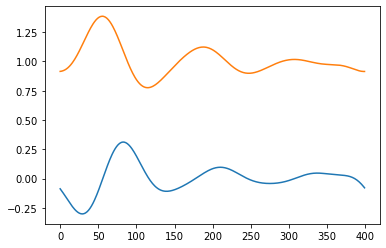

In [57]:
input0 = {
    "tpt": np.reshape(np.arange(0,400).astype('float32'),newshape=(400,1))
    }
muh_lyr = model.compare_lyr.params0toParams.layer_muh["0"]
muh_output0 = muh_lyr(input0).numpy()
varh_diag_lyr = model.compare_lyr.params0toParams.layer_varh_diag["0"]
varh_diag_output0 = varh_diag_lyr(input0).numpy()

plt.figure()
plt.plot(muh_output0)
plt.plot(varh_diag_output0)